In [2]:
import matplotlib.pyplot as plt # use to show images
import matplotlib.image as mpimg # use to read images
import cv2
from PIL import Image
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
GeForce RTX 2080 Ti


## 1. DCGAN
- 模型描述
    - 超參數(照著原始論文)
        - Learning rate: 0.0002
        - Batch size: 128
        - Image sizeL 64
        - Dimension of z: 100
        - Number of epoch: 30
    - 網路設定(照著原始論文）
        - Generator
            - 100\*1\*1 => 1024\*4\*4
            - 1024\*4\*4 => 512\*8\*8
            - 512\*8\*8 => 256\*16\*16
            - 256\*16\*16 => 128\*32\*32
            - 128\*32\*32 => 3\*64\*64
        - Discriminator
            - 3\*64\*64 => 128\*32\*32
            - 128\*32\*32 => 256\*16\*16
            - 256\*16\*16 => 512\*8\*8
            - 512\*8\*8 => 1024\*4\*4
            - 1024\*4\*4 => 100\*1\*1
    - 照著原始的論文在他規定的地方使用了特定的東西
        - 在Generator的最後使用tanh()，並在過程上的每一層加上batch_norm/ReLU
        - 在Discriminator的最後使用Sigmoid()，並在過程上的每一層加上batch_norm/LeakyReLU(0.2)
        - 網路的初始參數設定成mean = 0.0, std = 0.02
            

In [3]:
# Hyperparameters 
LR = 0.0002
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 30
#
# Generator & Discriminator model
#
class Discriminator(nn.Module):
    def __init__(self,channels_img):
        super(Discriminator,self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, 128, kernel_size=4, stride=2, padding=1 # 3*64*64 => 128*32*32
            ),
            nn.LeakyReLU(0.2),
            self.block(128, 256, 4, 2, 1),                 # 128*32*32 => 256*16*16
            self.block(256, 512, 4, 2, 1),                 # 256*16*16 => 512*8*8
            self.block(512, 1024, 4, 2, 1),                # 512*8*8 => 1024*4*4
            nn.Conv2d(1024, 1, 4, 2, 0),                   # 4*4*1024 => 1*1*1
            nn.Sigmoid(),                                  # converting value to [0,1]
        )
        self.initialize_weights()
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
    def forward(self,x):
        return self.disc(x)
class Generator(nn.Module):
    def __init__(self,z_dim, channels_img):
        super(Generator,self).__init__()
        # Input: N x 100 x 1 x 1
        self.gen = nn.Sequential(
            self.block(z_dim, 1024, 4, 1, 0),       # 100*1*1 => 1024*4*4
            self.block(1024, 512, 4, 2, 1),         # 1024*4*4 => 512*8*8
            self.block(512, 256, 4, 2, 1),          # 512*8*8 => 256*16*16
            self.block(256, 128, 4, 2, 1),          # 256*16*16 => 128*32*32
            nn.ConvTranspose2d(                     # 128*32*32 => 3*64*64
                128, 
                channels_img, 
                kernel_size=4, 
                stride=2, 
                padding=1
            ),      
            nn.Tanh(),
        )
        self.initialize_weights()
    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)
    def forward(self,x):
        return self.gen(x)

# Data preprocessing
transforms_ = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5]),
    ]
)


In [4]:
#
# Read images(with PIL)
#
img = Image.open("./img_align_celeba/000001.jpg").convert('RGB')
print(img.size, img.mode)
img = transforms_(img)
print(img.shape)
file = open('img_name.txt','r')
file_name = []
while(True):
    line = file.readline()
    if(not line):
        break
    file_name.append(line.split('\n')[0])
file.close()
real_images= []
cnt = 0
for name in file_name:
    img = Image.open('./img_align_celeba/'+name).convert('RGB')
    real_images.append(transforms_(img))
    cnt += 1
    if(cnt == 50000):
        break
print(len(real_images))

(178, 218) RGB
torch.Size([3, 64, 64])
50000


In [5]:
# Dataloader, model, optimizer, loss function
dataloader = DataLoader(real_images, batch_size=BATCH_SIZE, shuffle=True)

gen = Generator(Z_DIM, CHANNELS_IMG).to(device)
disc = Discriminator(CHANNELS_IMG).to(device)

opt_gen = torch.optim.Adam(gen.parameters(), lr=LR, betas=(0.5,0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LR, betas=(0.5,0.999))
loss_func = nn.BCELoss()

# make fixed noise
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)


# set training mode
gen.train()
disc.train()
step = 0

# loss of gen & disc
gen_loss_list = []
disc_loss_list = []

# record temp result in training
result_5 = []
result_30 = []

# training process
for epoch in range(NUM_EPOCHS):
    for i, real in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise).to(device)
        
        # Train Discriminator: max log(D(x)) + log(1 - D(G(Z))
        disc_real = disc(real).reshape(-1) # N x 1 x 1 x 1 = N
        loss_disc_real = loss_func(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = loss_func(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        
        disc.zero_grad() # clear gradient
        loss_disc.backward(retain_graph=True) # backpropagation
        opt_disc.step() # optimize network
        
        # Train Generator: min log(1 - D(G(z)))  <-->  max log(D(G(z)))
        output = disc(fake).reshape(-1) # N x 1 x 1 x 1 = N
        loss_gen = loss_func(output, torch.ones_like(output))
        
        gen.zero_grad() # clear gradient
        loss_gen.backward() # backpropagation
        opt_gen.step() # optimize network
        
        # Print loss & print images to tensorboard
        if i % 10 == 0:
            gen_loss_list.append(loss_gen.item())
            disc_loss_list.append(loss_disc.item())
            print("Epoch:",epoch,", Batch:",i,"/",len(dataloader),", Loss of Disc:",loss_disc.item(),", Loss of Gen:",loss_gen.item())

            step += 1
    if(epoch == 4):
        with torch.no_grad():
            result = gen(fixed_noise).to("cpu")
            result = result.numpy()
            result_5 = result
    elif(epoch == 29):
        with torch.no_grad():
            result = gen(fixed_noise).to("cpu")
            result = result.numpy()
            result_30 = result

Epoch: 0 , Batch: 0 / 391 , Loss of Disc: 0.6942622661590576 , Loss of Gen: 0.9778431057929993
Epoch: 0 , Batch: 10 / 391 , Loss of Disc: 0.15012355148792267 , Loss of Gen: 2.275477647781372
Epoch: 0 , Batch: 20 / 391 , Loss of Disc: 0.05660409480333328 , Loss of Gen: 3.056419610977173
Epoch: 0 , Batch: 30 / 391 , Loss of Disc: 0.0347319021821022 , Loss of Gen: 3.5399727821350098
Epoch: 0 , Batch: 40 / 391 , Loss of Disc: 0.019732128828763962 , Loss of Gen: 4.02884578704834
Epoch: 0 , Batch: 50 / 391 , Loss of Disc: 0.013189633376896381 , Loss of Gen: 4.360790729522705
Epoch: 0 , Batch: 60 / 391 , Loss of Disc: 0.010062444023787975 , Loss of Gen: 4.626335144042969
Epoch: 0 , Batch: 70 / 391 , Loss of Disc: 0.007889465428888798 , Loss of Gen: 4.858828544616699
Epoch: 0 , Batch: 80 / 391 , Loss of Disc: 0.006267951801419258 , Loss of Gen: 5.089008331298828
Epoch: 0 , Batch: 90 / 391 , Loss of Disc: 0.0052601792849600315 , Loss of Gen: 5.28121280670166
Epoch: 0 , Batch: 100 / 391 , Loss o

## 1-(a) Describe how you preprocess the dataset
- 把圖片resize成64*64的大小
- 把讀進來的PIL image轉成tensor
- 把圖片內每個pixel之channel的值normalize 到 mean = 0.5, std = 0.5

## 1-(b) Plot the learning curve for both generator and discriminator
- 結果如下圖Loss所示

## 1-(c) Draw some samples from generator at different training stages
- 結果如下所示，各為8*4的圖片集，分別是第5個epoch和第30個epoch時產生的

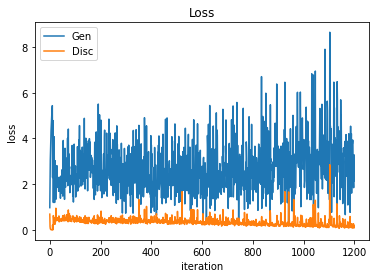

Epoch 5: 


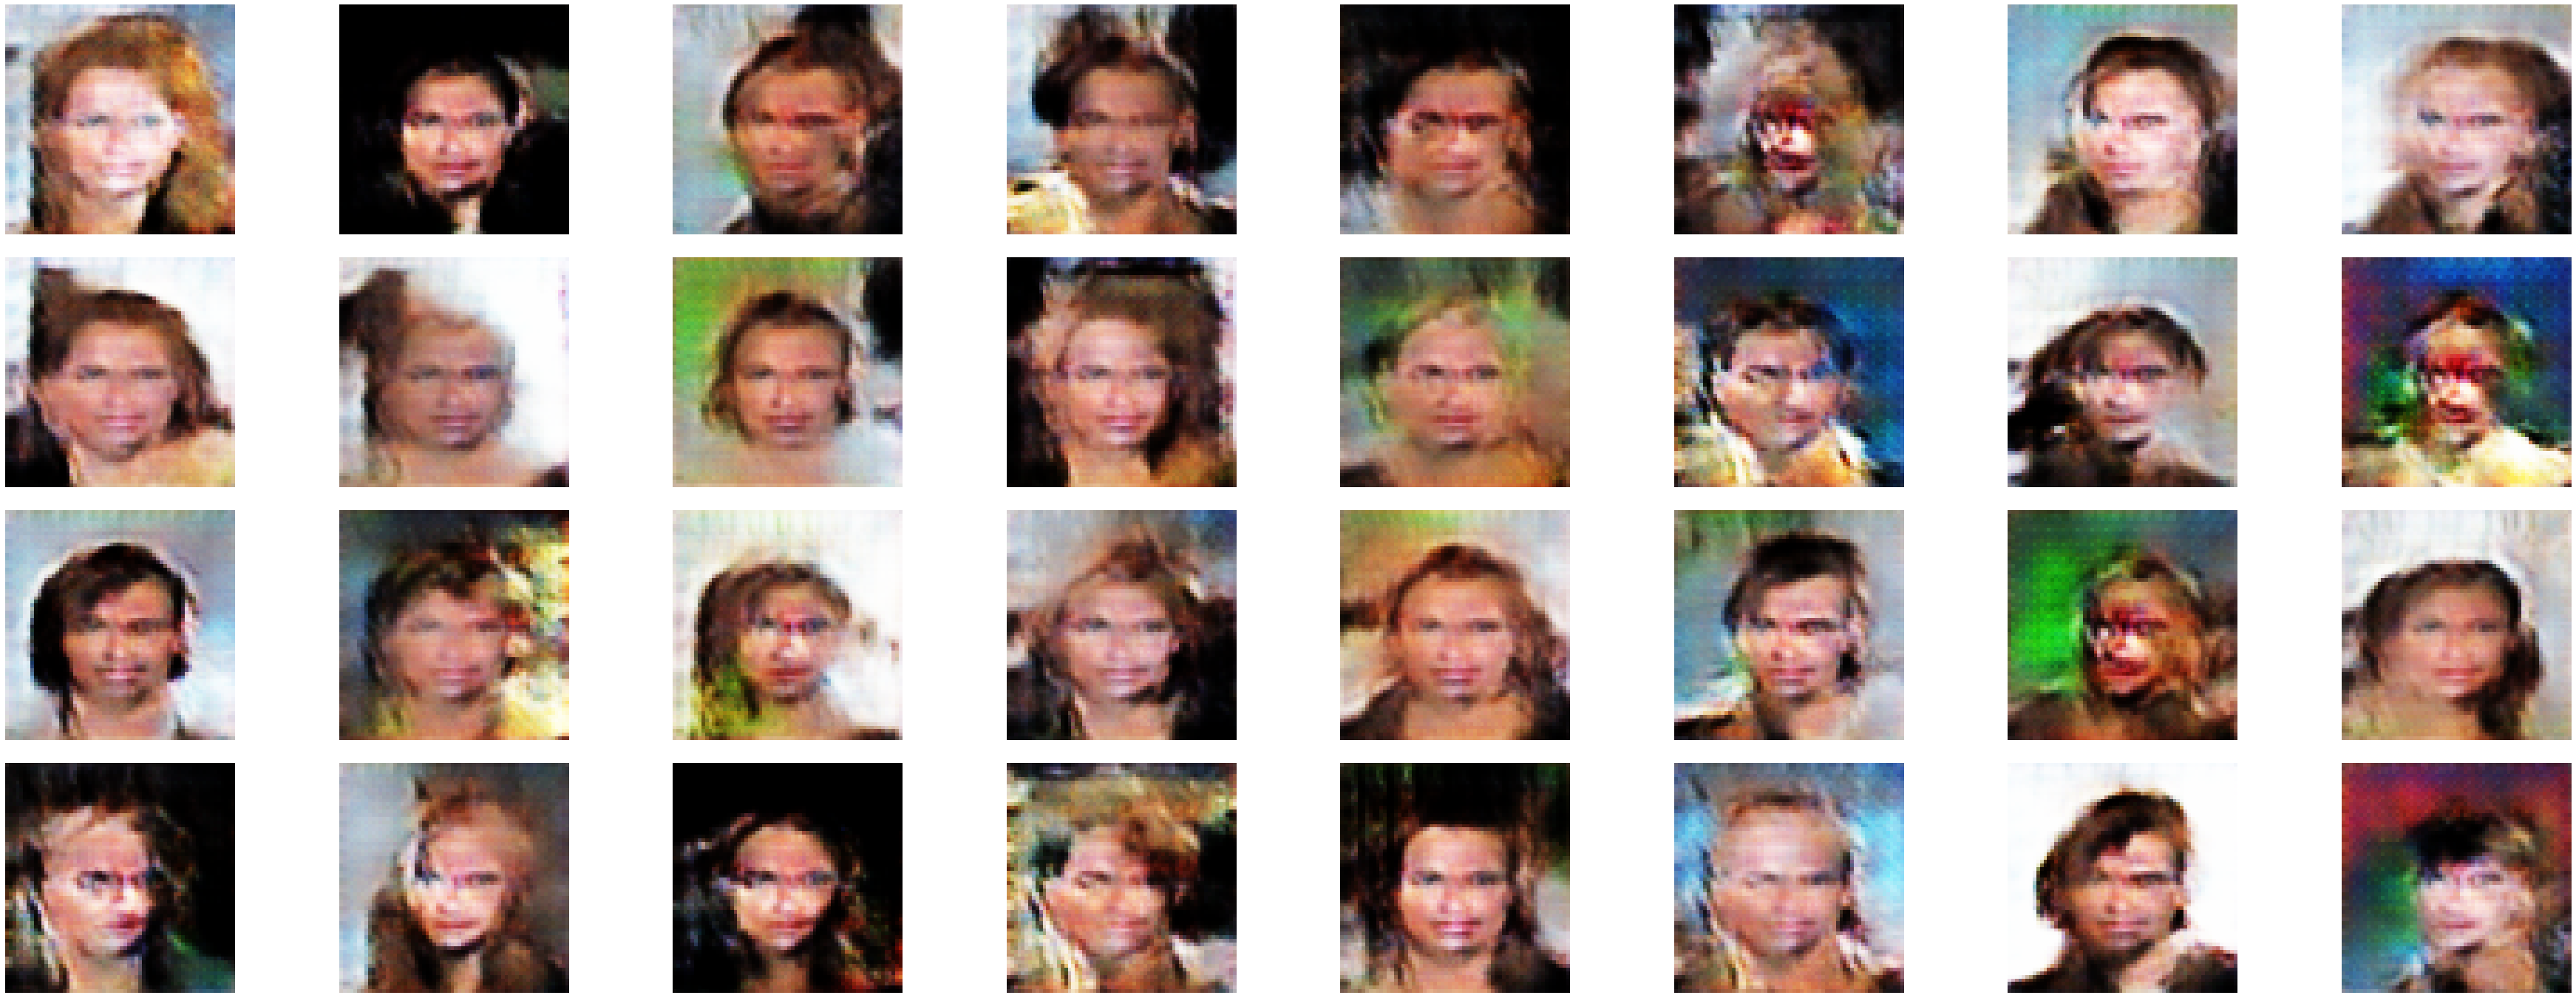

--------------------------------------------------------
Epoch 30: 


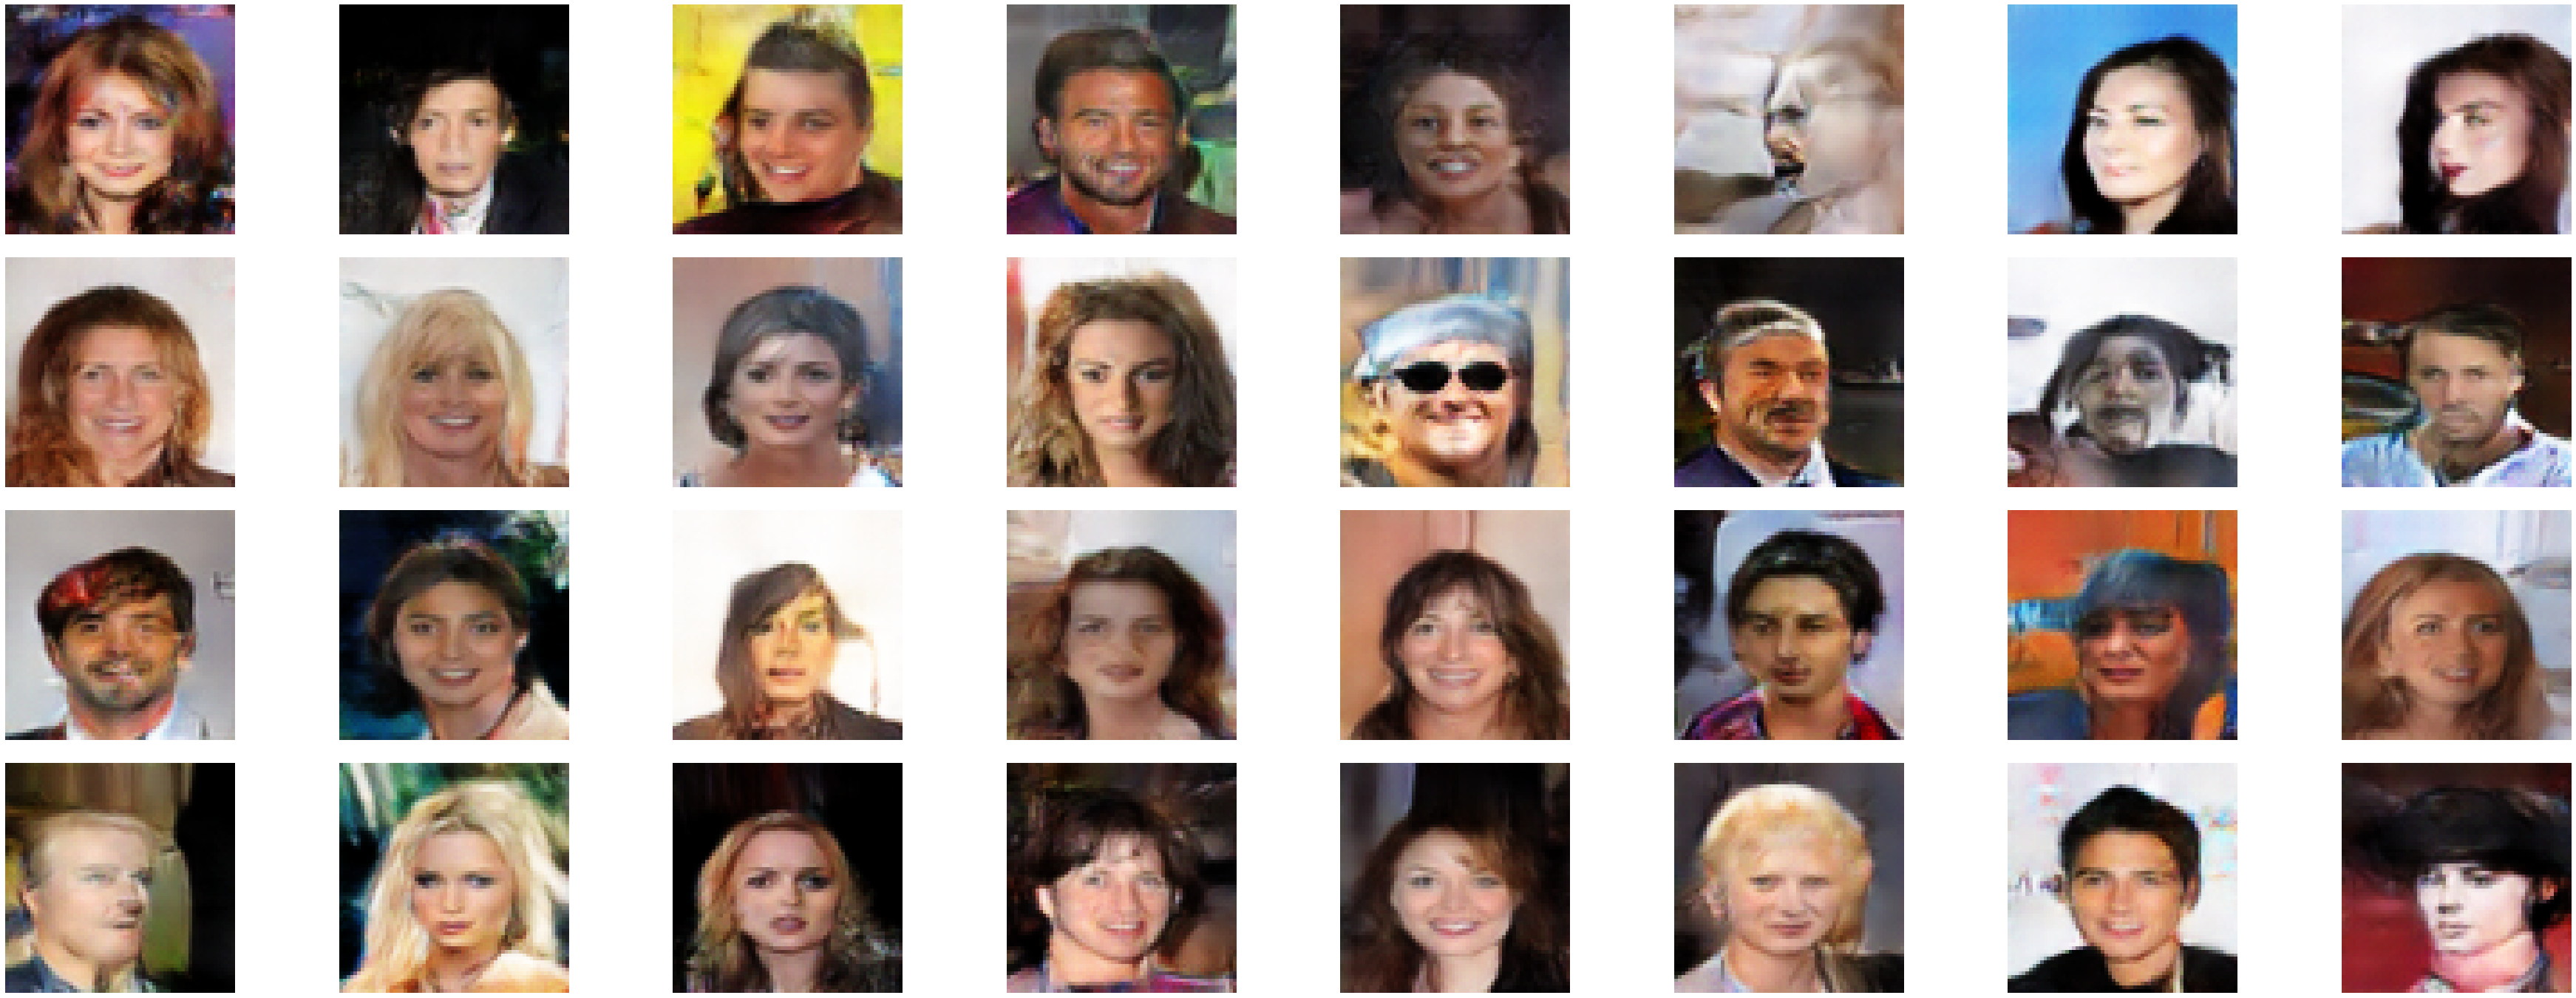

In [6]:
plt.plot(gen_loss_list,label='Gen')
plt.plot(disc_loss_list,label='Disc')
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

# plot result in epoch 5
print("Epoch 5: ")
result = result_5
fig=plt.figure(figsize=(64,64))
for i in range(32):
    ans = result[i].T
    ans = (ans+1.0)/2.0
    ans = ans.swapaxes(1,0)
    fig.add_subplot(4,8,(i+1))
    plt.imshow(ans)
    plt.axis('off')
plt.subplots_adjust(left=0.125,
                bottom=0.01, 
                right=0.9, 
                top=0.3, 
                wspace=0.1, 
                hspace=0.1)
plt.show()
print("--------------------------------------------------------")
print("Epoch 30: ")
# plot result in epoch 30
result = result_30
fig=plt.figure(figsize=(64,64))
for i in range(32):
    ans = result[i].T
    ans = (ans+1.0)/2.0
    ans = ans.swapaxes(1,0)
    fig.add_subplot(4,8,(i+1))
    plt.imshow(ans)
    plt.axis('off')
plt.subplots_adjust(left=0.125,
                bottom=0.01, 
                right=0.9, 
                top=0.3, 
                wspace=0.1, 
                hspace=0.1)
plt.show()

## 2-(a) Please decribe the meaning of the following four pictures during training of GAN
- 每張圖的意義如下
    - (A): 訓練Discriminator的過程，目標要在真實的分布(Input data)那邊得到1，而在冒牌的分布(Generator)那邊得到0
    - (B): 訓練開始前
    - (C): 訓練Generator的過程，目標要讓冒牌的分佈去貼近真實的分佈
    - (D): 訓練完成後，Generator的分佈貼合真實分佈，和Discriminator的分佈為一條直線y = 0.5，代表說他已經無法分出真/假圖片了
- 黑色虛線和x/z代表什麼？
    - Ans: Black dashed line即為data實際的distribution，z為一群uniform distribution的值，而x則為輸入z給generator而產生的distribution，也就是G(z)的distribution
- 哪個階段是在train gernerator？ 目標式為何？
    - (C)圖是在train Generator的過程
    - 目標式: $\Sigma$ log(1 - D(G(z)))
- 哪個階段是在train discriminator？ 目標式為何？
    - (A)圖是在train Discriminator的過程
    - 目標式: $\Sigma$ log(D(x)) + $\Sigma$ log(1 - D(G(z)) 
- 為什麼D(x) = 0.5的時候代表訓練結束? 
    - Ans: 因為代表此時無論generator產生了什麼照片，Discriminator都無法分辨這張照片是真的還是假的(真/假機率各為0.5)

## 2-(b) The Helvetica Scenario often happens during training GAN. Please explain why it occurs and how to avoid it.
- The Helvetica Scenario 就是mode collapse, 主要是因為只要Generator不論輸入的z是什麼，他發現只要一直生成一樣的x，而這個x剛好可以讓Discriminator分不出來，他就可以滿足目標式了，但是這樣卻沒辦法學習到真正data的distribution。
- 使用WGAN(Earth-Mover (EM) distance or Wasserstein-1 distance)可以有效避免mode collapse。

## 2-(c) Please compare VAE & GAN's results and describe the pros and cons of two models
- 由圖中可以看出VAE生成的圖片會比較模糊，這是因為VAE生成latent vector z的時候強制他擬合到有限维度的Gaussion Mixture Model上，所以導致在由Input x映射到latent vector z的過程中產生了不必要的information loss，這種不符合預設分佈的映射方式也造成了VAE恢復的圖片比較模糊。
- 而在GAN中它是透過Disciminator來進行優化的，使得Generator可以直接由隨機分佈的input z來生成圖片，所以不會有VAE的那種問題，也因此可以得到比較清晰的圖片
- 那他們兩個人的優點缺點如下
    - VAE: 
        - 優點: 有一個清楚的方式能夠判別訓練出來模型的好壞(例如log-likelihood)
        - 缺點: 因為上述提的原因，造成生成出來的圖片比較模糊
    - GAN:
        - 優點: 可以創造出來比較清晰的照片(相比於VAE)
        - 缺點: 除了用肉眼來看生成出來的圖片，沒有一個明確的方式來比較模型的好壞。另外，GAN也可能產生mode collapse的問題。